In [1]:
import torch
import numpy as np
import pandas as pd
import os

name = "criteo"
data_dir = "../data"
data_set_dir = os.path.join(data_dir, name)
data_set_dir = os.path.join(data_set_dir, "data.txt")
df = pd.read_csv(data_set_dir, sep="\t", header=None)
click_ts = df[df.columns[0]].to_numpy()
pay_ts = df[df.columns[1]].fillna(-1).to_numpy()
df = df[df.columns[2:]]
df.iloc[:,8:] = df.iloc[:,8:].fillna("").astype(str)
df.iloc[:,:8] = df.iloc[:,:8].fillna(-1).apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.rename(columns={col: str(col-2) for col in df.columns}, inplace=True)

In [2]:
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
num_bin_size = (64, 16, 128, 64, 128, 64, 512, 512)
cate_bin_size = (512, 128, 256, 256, 64, 256, 256, 16, 256)

def one_hot_encoding_sparse(indices, num_classes):
    row_index = torch.arange(indices.size(0))
    indices = torch.vstack((row_index, indices))
    values = torch.ones(indices.size(0), dtype=torch.int8)
    one_hot_sparse = torch.sparse_coo_tensor(indices, values, (indices.size(0), num_classes))
    return one_hot_sparse

def one_hot_encoding(indices, num_classes):
    one_hot = torch.zeros((indices.size(0), num_classes), dtype=torch.int8)
    one_hot.scatter_(1, indices.unsqueeze(1), 1)
    return one_hot

def one_hot_encoding_sparse_np(indices, num_classes):
    row_index = np.arange(indices.shape[0])
    data = np.ones(indices.shape[0])
    one_hot_sparse = csr_matrix((data, (row_index, indices)), shape=(indices.shape[0], num_classes))
    return one_hot_sparse

numerical_emb_concat = None
for i in range(0, 8):
    feat = df.iloc[:, i].values
    # Scale feature values to the range [0, num_bin_size[i]-1]
    scaled_feat = (feat * (num_bin_size[i]-1)).astype(int)
    dummy_matrix = one_hot_encoding_sparse_np(scaled_feat, num_bin_size[i])
    if numerical_emb_concat is None:
        numerical_emb_concat = dummy_matrix
    else:
        numerical_emb_concat = hstack((numerical_emb_concat, dummy_matrix))

# Concatenate one-hot encoded tensors along the second dimension (columns)
encoder = LabelEncoder()
for i in range(8, 17):
    feat = df.iloc[:, i]
    feat = encoder.fit_transform(feat)
    scaled_feat = ((feat - feat.min()) / (feat.max() - feat.min()) * (cate_bin_size[i - 8]-1)).astype(int)
    dummy_matrix = one_hot_encoding_sparse_np(scaled_feat, cate_bin_size[i - 8])
    if numerical_emb_concat is None:
        numerical_emb_concat = dummy_matrix
    else:
        numerical_emb_concat = hstack((numerical_emb_concat, dummy_matrix))

x = numerical_emb_concat.astype(bool)
num_sample = x.shape[0]
x = x.toarray()
print(num_sample)

15898883


In [3]:
import math
import const
# def linear_regression(x, input_dim, output_dim, batch_size=128):
#     # x: numpy
#
#     num_samples = x.shape[0]
#     num_batches = math.ceil(num_samples / batch_size)
#
#     # Convert x to a PyTorch tensor
#     x_tensor = torch.from_numpy(x).float()
#
#     bn = torch.nn.BatchNorm1d(input_dim).cuda()
#     p_linear = torch.nn.Linear(input_dim, output_dim).cuda()
#
#     # Placeholder for output tensor
#     p = torch.zeros(num_samples, output_dim)
#
#     for batch_idx in range(num_batches):
#         # Get the start and end indices for the current batch
#         start_idx = batch_idx * batch_size
#         end_idx = min(start_idx + batch_size, num_samples)
#
#         # Load the batch to GPU
#         x_batch = x_tensor[start_idx:end_idx].cuda()
#
#         # Process the batch
#         x_batch = bn(x_batch)
#         p_batch = p_linear(x_batch)
#         p_batch = torch.sigmoid(p_batch)
#
#         # Store the batch output in the placeholder tensor
#         p[start_idx:end_idx] = p_batch.cpu().detach()
#
#     p = p.numpy().reshape(-1)
#     return p
def linear_regression(x, input_dim, output_dim):
    # x: numpy

    x_tensor = torch.from_numpy(x).cuda().float()

    bn = torch.nn.BatchNorm1d(input_dim).cuda()
    p_linear = torch.nn.Linear(input_dim, output_dim).cuda()
    x_tensor = bn(x_tensor)
    p = p_linear(x_tensor)
    p = torch.sigmoid(p).cpu().detach().numpy().reshape(-1)
    return p
p_list = np.array([])
all_index = np.arange(num_sample)
total_batch = 100
batch_size = num_sample // total_batch
for i in range(total_batch):
    torch.cuda.empty_cache()
    print("\r%s" % i, end="")
    if i == total_batch - 1:
        index = all_index[i * batch_size:]
    else:
        index = all_index[i * batch_size: (i + 1) * batch_size]

    p = linear_regression(x[index], const.CATEGORICAL_EMB_SIZE+const.NUMERICAL_EMB_SIZE, 1)
    p_list = np.concatenate((p_list, p))

99

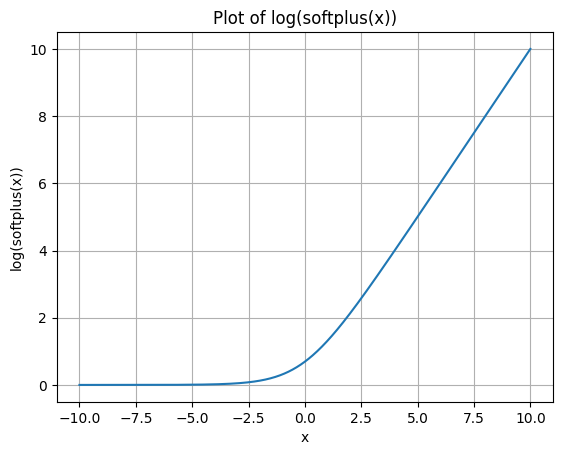

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def softplus(x):
    return np.log(1 + np.exp(x))

x = np.linspace(-10, 10, 1000)
y = (softplus(x))

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('log(softplus(x))')
plt.title('Plot of log(softplus(x))')
plt.grid()
plt.show()

In [1]:
import numpy as np
name = "criteo"
x_test = np.load("../datasets/" + name + "/y_test.npy", allow_pickle=True)
print(x_test.shape)

(8197520,)
